Impulse Noise Restoration via CSC
=================================

This example demonstrates the removal of salt & pepper noise from a colour image using convolutional sparse coding, with a colour dictionary [[31]](http://sporco.rtfd.org/en/latest/zreferences.html#wohlberg-2016-convolutional) and with an $\ell_1$ data fidelity term, an $\ell_1$ regularisation term, and an additional gradient regularization term [[32]](http://sporco.rtfd.org/en/latest/zreferences.html#wohlberg-2016-convolutional2)

  $$\mathrm{argmin}_\mathbf{x} \; \sum_c \left\| \sum_m \mathbf{d}_{c,m} * \mathbf{x}_m -\mathbf{s}_c \right\|_1 + \lambda \sum_m \| \mathbf{x}_m \|_1 + (\mu/2) \sum_i \sum_m \| G_i \mathbf{x}_m \|_2^2$$

where $\mathbf{d}_{c,m}$ is channel $c$ of the $m^{\text{th}}$ dictionary filter, $\mathbf{x}_m$ is the coefficient map corresponding to the $m^{\text{th}}$ dictionary filter, $\mathbf{s}_c$ is channel $c$ of the input image, and $G_i$ is an operator computing the derivative along spatial index $i$.

This example uses the GPU accelerated version of [admm.cbpdn](http://sporco.rtfd.org/en/latest/modules/sporco.admm.cbpdn.html#module-sporco.admm.cbpdn) within the [sporco.cupy](http://sporco.rtfd.org/en/latest/modules/sporco.cupy.html#module-sporco.cupy) subpackage.

In [1]:
from __future__ import print_function
from builtins import input
from builtins import range

import pyfftw   # See https://github.com/pyFFTW/pyFFTW/issues/40
import numpy as np

from sporco import util
from sporco import plot
plot.config_notebook_plotting()
import sporco.metric as sm
import sporco.linalg as sl
from sporco.cupy import cupy_enabled, np2cp, cp2np
from sporco.cupy import select_device_by_load, gpu_info
from sporco.cupy import cp
from sporco.cupy.admm import cbpdn

Boundary artifacts are handled by performing a symmetric extension on the image to be denoised and then cropping the result to the original image support. This approach is simpler than the boundary handling strategies that involve the insertion of a spatial mask into the data fidelity term, and for many problems gives results of comparable quality. The functions defined here implement symmetric extension and cropping of images.

In [2]:
def pad(x, n=8):

    if x.ndim == 2:
        return np.pad(x, n, mode='symmetric')
    else:
        return np.pad(x, ((n, n), (n, n), (0, 0)), mode='symmetric')


def crop(x, n=8):

    return x[n:-n, n:-n]

Load a reference image and corrupt it with 33% salt and pepper noise. (The call to ``np.random.seed`` ensures that the pseudo-random noise is reproducible.)

In [3]:
img = util.ExampleImages().image('monarch.png', zoom=0.5, scaled=True,
                                 idxexp=np.s_[:, 160:672])
np.random.seed(12345)
imgn = util.spnoise(img, 0.33)

We use a colour dictionary. The impulse denoising problem is solved by appending some additional filters to the learned dictionary ``D0``, which is one of those distributed with SPORCO. These additional components consist of a set of three impulse filters, one per colour channel, that will represent the low frequency image components when used together with a gradient penalty on the coefficient maps, as discussed below.

In [4]:
D0 = util.convdicts()['RGB:8x8x3x64']
Di = np.zeros(D0.shape[0:2] + (3, 3), dtype=np.float32)
np.fill_diagonal(Di[0, 0], 1.0)
D = np.concatenate((Di, D0), axis=3)

The problem is solved using class [admm.cbpdn.ConvL1L1Grd](http://sporco.rtfd.org/en/latest/modules/sporco.admm.cbpdn.html#sporco.admm.cbpdn.ConvL1L1Grd), which implements a convolutional sparse coding problem with an $\ell_1$ data fidelity term, an $\ell_1$ regularisation term, and an additional gradient regularization term [[32]](http://sporco.rtfd.org/en/latest/zreferences.html#wohlberg-2016-convolutional2), as defined above. The regularization parameters for the $\ell_1$ and gradient terms are ``lmbda`` and ``mu`` respectively. Setting correct weighting arrays for these regularization terms is critical to obtaining good performance. For the $\ell_1$ norm, the weights on the filters that are intended to represent low frequency components are set to zero (we only want them penalised by the gradient term), and the weights of the remaining filters are set to zero. For the gradient penalty, all weights are set to zero except for those corresponding to the filters intended to represent low frequency components, which are set to unity.

In [5]:
lmbda = 3e0
mu = 2e1
w1 = np.ones((1, 1, 1, 1, D.shape[-1]), dtype=np.float32)
w1[..., 0:3] = 0.0
wg = np.zeros((D.shape[-1]), dtype=np.float32)
wg[..., 0:3] = 1.0

opt = cbpdn.ConvL1L1Grd.Options({'Verbose': True, 'MaxMainIter': 200,
                                'RelStopTol': 5e-3, 'AuxVarObj': False,
                                'rho': 4e1, 'RelaxParam': 1.8,
                                'L1Weight': np2cp(w1),
                                'GradWeight': np2cp(wg)})

Initialise the [admm.cbpdn.ConvL1L1Grd](http://sporco.rtfd.org/en/latest/modules/sporco.admm.cbpdn.html#sporco.admm.cbpdn.ConvL1L1Grd) object and call the ``solve`` method.

In [6]:
if not cupy_enabled():
    print('CuPy/GPU device not available: running without GPU acceleration\n')
else:
    id = select_device_by_load()
    info = gpu_info()
    if info:
        print('Running on GPU %d (%s)\n' % (id, info[id].name))

b = cbpdn.ConvL1L1Grd(np2cp(D), np2cp(pad(imgn)), lmbda, mu, opt=opt, dimK=0)
X = cp2np(b.solve())

CuPy/GPU device not available: running without GPU acceleration

Itn   Fnc       DFid      Regℓ1     Regℓ2∇    r         s       
----------------------------------------------------------------


   0  2.21e+05  4.84e+04  5.19e+04  8.16e+02  4.42e-01  1.50e+00


   1  2.24e+05  5.18e+04  5.53e+04  3.43e+02  3.67e-01  1.42e+00


   2  1.97e+05  4.97e+04  4.82e+04  1.29e+02  2.80e-01  1.50e+00


   3  1.70e+05  4.89e+04  3.98e+04  1.15e+02  2.10e-01  1.53e+00


   4  1.50e+05  4.64e+04  3.40e+04  7.75e+01  1.61e-01  1.58e+00


   5  1.30e+05  4.54e+04  2.77e+04  8.42e+01  1.20e-01  1.53e+00


   6  1.15e+05  4.39e+04  2.31e+04  7.67e+01  9.33e-02  1.61e+00


   7  1.05e+05  4.34e+04  1.99e+04  8.08e+01  7.15e-02  1.42e+00


   8  9.27e+04  4.23e+04  1.63e+04  7.68e+01  5.59e-02  1.65e+00


   9  8.76e+04  4.17e+04  1.48e+04  7.76e+01  4.47e-02  1.40e+00


  10  7.90e+04  4.10e+04  1.22e+04  7.63e+01  3.64e-02  1.73e+00


  11  7.38e+04  4.05e+04  1.06e+04  7.54e+01  3.03e-02  1.41e+00


  12  7.01e+04  4.00e+04  9.55e+03  7.48e+01  2.61e-02  1.76e+00


  13  6.57e+04  3.95e+04  8.24e+03  7.38e+01  2.27e-02  1.52e+00


  14  6.27e+04  3.90e+04  7.42e+03  7.35e+01  2.01e-02  1.72e+00


  15  6.00e+04  3.86e+04  6.65e+03  7.30e+01  1.80e-02  1.67e+00


  16  5.76e+04  3.83e+04  5.95e+03  7.29e+01  1.63e-02  1.65e+00


  17  5.59e+04  3.79e+04  5.50e+03  7.27e+01  1.50e-02  1.73e+00


  18  5.46e+04  3.76e+04  5.16e+03  7.26e+01  1.39e-02  1.66e+00


  19  5.35e+04  3.74e+04  4.90e+03  7.25e+01  1.28e-02  1.72e+00


  20  5.25e+04  3.72e+04  4.63e+03  7.25e+01  1.19e-02  1.69e+00


  21  5.14e+04  3.70e+04  4.31e+03  7.25e+01  1.11e-02  1.68e+00


  22  5.05e+04  3.68e+04  4.09e+03  7.25e+01  1.03e-02  1.69e+00


  23  4.99e+04  3.67e+04  3.94e+03  7.26e+01  9.69e-03  1.66e+00


  24  4.94e+04  3.65e+04  3.81e+03  7.26e+01  9.12e-03  1.65e+00


  25  4.90e+04  3.64e+04  3.69e+03  7.28e+01  8.59e-03  1.65e+00


  26  4.85e+04  3.64e+04  3.58e+03  7.29e+01  8.11e-03  1.63e+00


  27  4.81e+04  3.63e+04  3.46e+03  7.30e+01  7.66e-03  1.62e+00


  28  4.77e+04  3.62e+04  3.33e+03  7.31e+01  7.23e-03  1.59e+00


  29  4.73e+04  3.62e+04  3.22e+03  7.32e+01  6.84e-03  1.57e+00


  30  4.69e+04  3.61e+04  3.12e+03  7.34e+01  6.49e-03  1.55e+00


  31  4.66e+04  3.61e+04  3.02e+03  7.35e+01  6.16e-03  1.53e+00


  32  4.63e+04  3.61e+04  2.92e+03  7.37e+01  5.86e-03  1.51e+00


  33  4.60e+04  3.60e+04  2.84e+03  7.38e+01  5.57e-03  1.48e+00


  34  4.58e+04  3.60e+04  2.77e+03  7.39e+01  5.32e-03  1.45e+00


  35  4.56e+04  3.60e+04  2.71e+03  7.41e+01  5.09e-03  1.42e+00


  36  4.54e+04  3.60e+04  2.65e+03  7.42e+01  4.87e-03  1.39e+00


  37  4.52e+04  3.60e+04  2.59e+03  7.43e+01  4.66e-03  1.36e+00


  38  4.50e+04  3.60e+04  2.53e+03  7.45e+01  4.46e-03  1.32e+00


  39  4.48e+04  3.60e+04  2.46e+03  7.46e+01  4.26e-03  1.29e+00


  40  4.46e+04  3.59e+04  2.40e+03  7.47e+01  4.08e-03  1.26e+00


  41  4.45e+04  3.59e+04  2.35e+03  7.48e+01  3.91e-03  1.22e+00


  42  4.43e+04  3.59e+04  2.30e+03  7.50e+01  3.75e-03  1.19e+00


  43  4.42e+04  3.59e+04  2.25e+03  7.51e+01  3.60e-03  1.16e+00


  44  4.41e+04  3.59e+04  2.21e+03  7.52e+01  3.46e-03  1.12e+00


  45  4.40e+04  3.59e+04  2.17e+03  7.54e+01  3.33e-03  1.08e+00


  46  4.38e+04  3.59e+04  2.13e+03  7.55e+01  3.21e-03  1.05e+00


  47  4.37e+04  3.59e+04  2.10e+03  7.56e+01  3.09e-03  1.02e+00


  48  4.36e+04  3.59e+04  2.06e+03  7.57e+01  2.98e-03  9.83e-01


  49  4.35e+04  3.59e+04  2.02e+03  7.58e+01  2.87e-03  9.51e-01


  50  4.34e+04  3.59e+04  1.99e+03  7.59e+01  2.77e-03  9.19e-01


  51  4.33e+04  3.59e+04  1.96e+03  7.60e+01  2.67e-03  8.89e-01


  52  4.32e+04  3.59e+04  1.92e+03  7.61e+01  2.58e-03  8.63e-01


  53  4.31e+04  3.59e+04  1.90e+03  7.62e+01  2.49e-03  8.41e-01


  54  4.31e+04  3.59e+04  1.87e+03  7.63e+01  2.41e-03  8.20e-01


  55  4.30e+04  3.59e+04  1.84e+03  7.64e+01  2.33e-03  7.98e-01


  56  4.29e+04  3.59e+04  1.82e+03  7.64e+01  2.26e-03  7.74e-01


  57  4.29e+04  3.59e+04  1.80e+03  7.65e+01  2.19e-03  7.48e-01


  58  4.28e+04  3.59e+04  1.77e+03  7.66e+01  2.12e-03  7.23e-01


  59  4.27e+04  3.59e+04  1.75e+03  7.66e+01  2.06e-03  6.99e-01


  60  4.27e+04  3.59e+04  1.73e+03  7.67e+01  2.00e-03  6.77e-01


  61  4.26e+04  3.59e+04  1.71e+03  7.67e+01  1.94e-03  6.57e-01


  62  4.26e+04  3.59e+04  1.69e+03  7.68e+01  1.88e-03  6.37e-01


  63  4.25e+04  3.59e+04  1.68e+03  7.68e+01  1.82e-03  6.18e-01


  64  4.24e+04  3.59e+04  1.66e+03  7.68e+01  1.77e-03  5.99e-01


  65  4.24e+04  3.59e+04  1.64e+03  7.69e+01  1.72e-03  5.82e-01


  66  4.23e+04  3.59e+04  1.62e+03  7.69e+01  1.67e-03  5.66e-01


  67  4.23e+04  3.59e+04  1.61e+03  7.69e+01  1.63e-03  5.50e-01


  68  4.23e+04  3.59e+04  1.59e+03  7.70e+01  1.58e-03  5.37e-01


  69  4.22e+04  3.59e+04  1.58e+03  7.70e+01  1.54e-03  5.24e-01


  70  4.22e+04  3.59e+04  1.56e+03  7.70e+01  1.49e-03  5.11e-01


  71  4.21e+04  3.59e+04  1.55e+03  7.71e+01  1.45e-03  4.98e-01


  72  4.21e+04  3.59e+04  1.54e+03  7.71e+01  1.42e-03  4.85e-01


  73  4.21e+04  3.59e+04  1.53e+03  7.71e+01  1.38e-03  4.73e-01


  74  4.20e+04  3.59e+04  1.52e+03  7.71e+01  1.34e-03  4.60e-01


  75  4.20e+04  3.59e+04  1.51e+03  7.72e+01  1.31e-03  4.48e-01


  76  4.20e+04  3.59e+04  1.49e+03  7.72e+01  1.27e-03  4.37e-01


  77  4.19e+04  3.59e+04  1.48e+03  7.72e+01  1.24e-03  4.26e-01


  78  4.19e+04  3.59e+04  1.47e+03  7.72e+01  1.21e-03  4.15e-01


  79  4.19e+04  3.59e+04  1.46e+03  7.73e+01  1.18e-03  4.05e-01


  80  4.18e+04  3.59e+04  1.45e+03  7.73e+01  1.15e-03  3.94e-01


  81  4.18e+04  3.59e+04  1.44e+03  7.73e+01  1.12e-03  3.84e-01


  82  4.18e+04  3.59e+04  1.43e+03  7.73e+01  1.09e-03  3.74e-01


  83  4.17e+04  3.59e+04  1.42e+03  7.74e+01  1.06e-03  3.64e-01


  84  4.17e+04  3.59e+04  1.41e+03  7.74e+01  1.04e-03  3.55e-01


  85  4.17e+04  3.59e+04  1.41e+03  7.74e+01  1.01e-03  3.46e-01


  86  4.17e+04  3.59e+04  1.40e+03  7.74e+01  9.88e-04  3.38e-01


  87  4.16e+04  3.59e+04  1.39e+03  7.74e+01  9.64e-04  3.30e-01


  88  4.16e+04  3.59e+04  1.38e+03  7.74e+01  9.41e-04  3.23e-01


  89  4.16e+04  3.59e+04  1.38e+03  7.75e+01  9.19e-04  3.15e-01


  90  4.16e+04  3.59e+04  1.37e+03  7.75e+01  8.97e-04  3.08e-01


  91  4.16e+04  3.59e+04  1.36e+03  7.75e+01  8.76e-04  3.01e-01


  92  4.15e+04  3.59e+04  1.36e+03  7.75e+01  8.56e-04  2.94e-01


  93  4.15e+04  3.59e+04  1.35e+03  7.75e+01  8.36e-04  2.87e-01


  94  4.15e+04  3.59e+04  1.34e+03  7.75e+01  8.17e-04  2.80e-01


  95  4.15e+04  3.59e+04  1.34e+03  7.75e+01  7.98e-04  2.73e-01


  96  4.15e+04  3.59e+04  1.33e+03  7.76e+01  7.80e-04  2.67e-01


  97  4.14e+04  3.59e+04  1.32e+03  7.76e+01  7.63e-04  2.60e-01


  98  4.14e+04  3.59e+04  1.32e+03  7.76e+01  7.46e-04  2.53e-01


  99  4.14e+04  3.59e+04  1.31e+03  7.76e+01  7.29e-04  2.47e-01


 100  4.14e+04  3.59e+04  1.31e+03  7.76e+01  7.13e-04  2.41e-01


 101  4.14e+04  3.59e+04  1.30e+03  7.77e+01  6.97e-04  2.35e-01


 102  4.14e+04  3.59e+04  1.30e+03  7.77e+01  6.81e-04  2.30e-01


 103  4.14e+04  3.59e+04  1.29e+03  7.77e+01  6.66e-04  2.24e-01


 104  4.13e+04  3.59e+04  1.29e+03  7.77e+01  6.52e-04  2.19e-01


 105  4.13e+04  3.59e+04  1.28e+03  7.77e+01  6.38e-04  2.14e-01


 106  4.13e+04  3.59e+04  1.28e+03  7.77e+01  6.24e-04  2.10e-01


 107  4.13e+04  3.59e+04  1.27e+03  7.77e+01  6.10e-04  2.06e-01


 108  4.13e+04  3.59e+04  1.27e+03  7.78e+01  5.97e-04  2.02e-01


 109  4.13e+04  3.59e+04  1.27e+03  7.78e+01  5.85e-04  1.98e-01


 110  4.13e+04  3.59e+04  1.26e+03  7.78e+01  5.72e-04  1.94e-01


 111  4.12e+04  3.59e+04  1.26e+03  7.78e+01  5.60e-04  1.90e-01


 112  4.12e+04  3.59e+04  1.25e+03  7.78e+01  5.49e-04  1.86e-01


 113  4.12e+04  3.59e+04  1.25e+03  7.78e+01  5.37e-04  1.82e-01


 114  4.12e+04  3.59e+04  1.25e+03  7.78e+01  5.26e-04  1.79e-01


 115  4.12e+04  3.59e+04  1.24e+03  7.78e+01  5.15e-04  1.75e-01


 116  4.12e+04  3.59e+04  1.24e+03  7.78e+01  5.04e-04  1.71e-01


 117  4.12e+04  3.59e+04  1.24e+03  7.79e+01  4.94e-04  1.68e-01


 118  4.12e+04  3.59e+04  1.23e+03  7.79e+01  4.83e-04  1.64e-01


 119  4.12e+04  3.59e+04  1.23e+03  7.79e+01  4.73e-04  1.61e-01


 120  4.12e+04  3.59e+04  1.23e+03  7.79e+01  4.64e-04  1.57e-01


 121  4.11e+04  3.59e+04  1.22e+03  7.79e+01  4.54e-04  1.54e-01


 122  4.11e+04  3.59e+04  1.22e+03  7.79e+01  4.45e-04  1.50e-01


 123  4.11e+04  3.59e+04  1.22e+03  7.79e+01  4.36e-04  1.47e-01


 124  4.11e+04  3.59e+04  1.21e+03  7.79e+01  4.28e-04  1.43e-01


 125  4.11e+04  3.59e+04  1.21e+03  7.79e+01  4.20e-04  1.40e-01


 126  4.11e+04  3.59e+04  1.21e+03  7.79e+01  4.11e-04  1.37e-01


 127  4.11e+04  3.59e+04  1.20e+03  7.79e+01  4.03e-04  1.34e-01


 128  4.11e+04  3.59e+04  1.20e+03  7.79e+01  3.95e-04  1.31e-01


 129  4.11e+04  3.59e+04  1.20e+03  7.80e+01  3.87e-04  1.29e-01


 130  4.11e+04  3.59e+04  1.20e+03  7.80e+01  3.80e-04  1.26e-01


 131  4.11e+04  3.59e+04  1.19e+03  7.80e+01  3.72e-04  1.24e-01


 132  4.11e+04  3.59e+04  1.19e+03  7.80e+01  3.65e-04  1.21e-01


 133  4.10e+04  3.59e+04  1.19e+03  7.80e+01  3.58e-04  1.19e-01


 134  4.10e+04  3.59e+04  1.19e+03  7.80e+01  3.51e-04  1.16e-01


 135  4.10e+04  3.59e+04  1.19e+03  7.80e+01  3.44e-04  1.14e-01


 136  4.10e+04  3.59e+04  1.18e+03  7.80e+01  3.38e-04  1.12e-01


 137  4.10e+04  3.59e+04  1.18e+03  7.80e+01  3.32e-04  1.10e-01


 138  4.10e+04  3.59e+04  1.18e+03  7.80e+01  3.25e-04  1.08e-01


 139  4.10e+04  3.59e+04  1.18e+03  7.80e+01  3.19e-04  1.06e-01


 140  4.10e+04  3.59e+04  1.17e+03  7.81e+01  3.13e-04  1.04e-01


 141  4.10e+04  3.59e+04  1.17e+03  7.81e+01  3.07e-04  1.02e-01


 142  4.10e+04  3.59e+04  1.17e+03  7.81e+01  3.02e-04  1.00e-01


 143  4.10e+04  3.59e+04  1.17e+03  7.81e+01  2.96e-04  9.79e-02


 144  4.10e+04  3.59e+04  1.17e+03  7.81e+01  2.91e-04  9.58e-02


 145  4.10e+04  3.59e+04  1.17e+03  7.81e+01  2.85e-04  9.37e-02


 146  4.10e+04  3.59e+04  1.16e+03  7.81e+01  2.80e-04  9.16e-02


 147  4.10e+04  3.59e+04  1.16e+03  7.81e+01  2.75e-04  8.97e-02


 148  4.10e+04  3.59e+04  1.16e+03  7.81e+01  2.70e-04  8.79e-02


 149  4.10e+04  3.59e+04  1.16e+03  7.81e+01  2.65e-04  8.61e-02


 150  4.09e+04  3.59e+04  1.16e+03  7.81e+01  2.60e-04  8.44e-02


 151  4.09e+04  3.59e+04  1.16e+03  7.81e+01  2.55e-04  8.29e-02


 152  4.09e+04  3.59e+04  1.15e+03  7.81e+01  2.51e-04  8.13e-02


 153  4.09e+04  3.59e+04  1.15e+03  7.81e+01  2.46e-04  7.98e-02


 154  4.09e+04  3.59e+04  1.15e+03  7.82e+01  2.42e-04  7.84e-02


 155  4.09e+04  3.59e+04  1.15e+03  7.82e+01  2.38e-04  7.70e-02


 156  4.09e+04  3.59e+04  1.15e+03  7.82e+01  2.33e-04  7.55e-02


 157  4.09e+04  3.59e+04  1.15e+03  7.82e+01  2.29e-04  7.43e-02


 158  4.09e+04  3.59e+04  1.15e+03  7.82e+01  2.25e-04  7.30e-02


 159  4.09e+04  3.59e+04  1.14e+03  7.82e+01  2.21e-04  7.18e-02


 160  4.09e+04  3.59e+04  1.14e+03  7.82e+01  2.17e-04  7.06e-02


 161  4.09e+04  3.59e+04  1.14e+03  7.82e+01  2.13e-04  6.95e-02


 162  4.09e+04  3.59e+04  1.14e+03  7.82e+01  2.10e-04  6.83e-02


 163  4.09e+04  3.59e+04  1.14e+03  7.82e+01  2.06e-04  6.70e-02


 164  4.09e+04  3.59e+04  1.14e+03  7.82e+01  2.02e-04  6.57e-02


 165  4.09e+04  3.59e+04  1.14e+03  7.82e+01  1.99e-04  6.44e-02


 166  4.09e+04  3.59e+04  1.14e+03  7.82e+01  1.95e-04  6.30e-02


 167  4.09e+04  3.59e+04  1.13e+03  7.82e+01  1.92e-04  6.16e-02


 168  4.09e+04  3.59e+04  1.13e+03  7.82e+01  1.89e-04  6.02e-02


 169  4.09e+04  3.59e+04  1.13e+03  7.82e+01  1.86e-04  5.90e-02


 170  4.09e+04  3.59e+04  1.13e+03  7.82e+01  1.82e-04  5.78e-02


 171  4.09e+04  3.59e+04  1.13e+03  7.82e+01  1.79e-04  5.67e-02


 172  4.09e+04  3.59e+04  1.13e+03  7.82e+01  1.76e-04  5.57e-02


 173  4.09e+04  3.59e+04  1.13e+03  7.82e+01  1.73e-04  5.48e-02


 174  4.09e+04  3.59e+04  1.13e+03  7.83e+01  1.70e-04  5.41e-02


 175  4.09e+04  3.59e+04  1.13e+03  7.83e+01  1.67e-04  5.34e-02


 176  4.08e+04  3.59e+04  1.12e+03  7.83e+01  1.64e-04  5.27e-02


 177  4.08e+04  3.59e+04  1.12e+03  7.83e+01  1.62e-04  5.20e-02


 178  4.08e+04  3.59e+04  1.12e+03  7.83e+01  1.59e-04  5.12e-02


 179  4.08e+04  3.59e+04  1.12e+03  7.83e+01  1.56e-04  5.03e-02


 180  4.08e+04  3.59e+04  1.12e+03  7.83e+01  1.54e-04  4.93e-02


 181  4.08e+04  3.59e+04  1.12e+03  7.83e+01  1.51e-04  4.82e-02


 182  4.08e+04  3.59e+04  1.12e+03  7.83e+01  1.49e-04  4.71e-02


 183  4.08e+04  3.59e+04  1.12e+03  7.83e+01  1.46e-04  4.60e-02


 184  4.08e+04  3.59e+04  1.12e+03  7.83e+01  1.44e-04  4.49e-02


 185  4.08e+04  3.59e+04  1.12e+03  7.83e+01  1.42e-04  4.40e-02


 186  4.08e+04  3.59e+04  1.12e+03  7.83e+01  1.39e-04  4.31e-02


 187  4.08e+04  3.59e+04  1.12e+03  7.83e+01  1.37e-04  4.24e-02


 188  4.08e+04  3.59e+04  1.11e+03  7.83e+01  1.35e-04  4.17e-02


 189  4.08e+04  3.59e+04  1.11e+03  7.83e+01  1.32e-04  4.10e-02


 190  4.08e+04  3.59e+04  1.11e+03  7.83e+01  1.30e-04  4.03e-02


 191  4.08e+04  3.59e+04  1.11e+03  7.83e+01  1.28e-04  3.97e-02


 192  4.08e+04  3.59e+04  1.11e+03  7.83e+01  1.26e-04  3.90e-02


 193  4.08e+04  3.59e+04  1.11e+03  7.83e+01  1.24e-04  3.83e-02


 194  4.08e+04  3.59e+04  1.11e+03  7.83e+01  1.22e-04  3.77e-02


 195  4.08e+04  3.59e+04  1.11e+03  7.83e+01  1.20e-04  3.70e-02


 196  4.08e+04  3.59e+04  1.11e+03  7.83e+01  1.18e-04  3.65e-02


 197  4.08e+04  3.59e+04  1.11e+03  7.83e+01  1.16e-04  3.60e-02


 198  4.08e+04  3.59e+04  1.11e+03  7.83e+01  1.14e-04  3.55e-02


 199  4.08e+04  3.59e+04  1.11e+03  7.83e+01  1.12e-04  3.50e-02
----------------------------------------------------------------


The denoised estimate of the image is just the reconstruction from all coefficient maps.

In [7]:
imgdp = cp2np(b.reconstruct().squeeze())
imgd = crop(imgdp)

Display solve time and denoising performance.

In [8]:
print("ConvL1L1Grd solve time: %5.2f s" % b.timer.elapsed('solve'))
print("Noisy image PSNR:    %5.2f dB" % sm.psnr(img, imgn))
print("Denoised image PSNR: %5.2f dB" % sm.psnr(img, imgd))

ConvL1L1Grd solve time: 309.40 s
Noisy image PSNR:    10.37 dB
Denoised image PSNR: 27.54 dB


Display the reference, noisy, and denoised images.

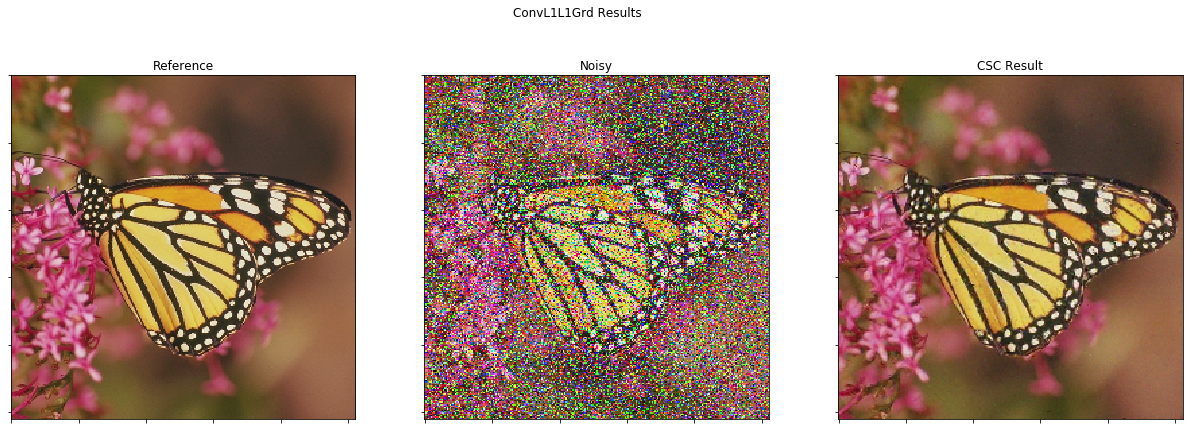

In [9]:
fig, ax = plot.subplots(nrows=1, ncols=3, figsize=(21, 7))
fig.suptitle('ConvL1L1Grd Results')
plot.imview(img, ax=ax[0], title='Reference', fig=fig)
plot.imview(imgn, ax=ax[1], title='Noisy', fig=fig)
plot.imview(imgd, ax=ax[2], title='CSC Result', fig=fig)
fig.show()

Display the low frequency image component.

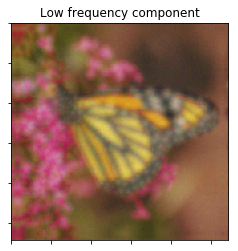

In [10]:
plot.imview(X[..., 0, 0:3].squeeze(), title='Low frequency component')